# 4 Implementation - Gaussian mixtures

In [1]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

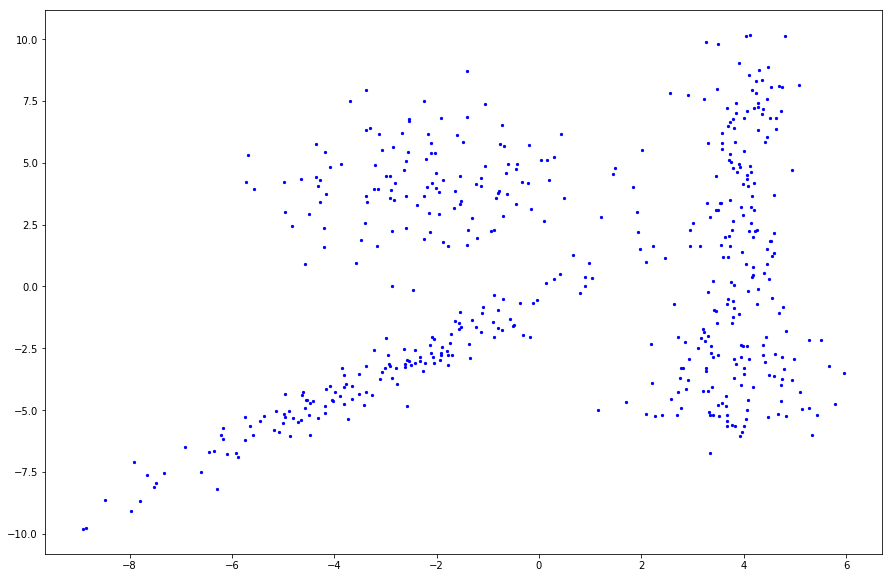

In [2]:
data = pd.read_csv('EMGaussian.data', sep=" ", header=None)
plt.figure(figsize=(15,10))
plt.scatter(data[0], data[1], color='blue', marker='o', s=5)
plt.show()

## 4. a) K-means agorithm

In [3]:
class Kmeans():
    def __init__(self, data, K):
        self.data = data
        self.K = K
        
        # parameters update by methods
        self.dist = []        
        self.randomInit()
        self.finalCentroids = None
        self.clusters = None
        
    def randomInit(self):
        self.initCentroids = np.array(data.sample(self.K))

    #def nearest(self, centroids):
    #    best_centroid = np.zeros(self.data.shape[0]) 
    #    for i, pt in self.data.iterrows():
    #        best_centroid[i] = np.argmin([np.linalg.norm((pt - coords)) for coords in centroids])
    #    return best_centroid
    
    def nearest(self, centroids):
        """
            Optimize version
        """
        return np.argmin(np.sum((data.values - centroids[:, np.newaxis])**2, axis=2), axis=0)

    #def distorsion(self, data):
    #    distance = 0
    #    for k in range(self.K):
    #        distance += np.sum((data[self.clusters == k] - self.finalCentroids[k])**2)
    #    return distance
    
    def distorsion(self, data):
        return np.sum([np.sum((data[self.clusters == k] - self.finalCentroids[k])**2) for k in range(self.K)])
    
    def getDistorsion(self):
        if self.dist:
            return self.dist[-1]

    def train(self, tol=0.01, max_iter=100):        
        self.clusters = np.array(data.shape[0])

        # save final centroids
        self.finalCentroids = self.initCentroids.copy()
        
        i = 0
        while len(self.dist) < 2 or ((i < max_iter and (np.absolute(self.dist[-1] - self.dist[-2])) > tol)):
            self.clusters = self.nearest(self.finalCentroids)

            # update centroids
            for k in range(self.K):
                self.finalCentroids[k] = np.mean(data[self.clusters == k])

            # add distorsion measure at each iteration
            self.dist.append(self.distorsion(data.values))
            
            i += 1
        
        return self.clusters, self.finalCentroids
    
    def plot(self):
        gs = gridspec.GridSpec(2, 2)
        pl.figure(figsize=(15,12))
        ax = pl.subplot(gs[0,0])
        
        # first plot: display position of initial centroids
        pl.scatter(data[0], data[1], color='b', s=10)
        pl.title('Initial centroids')
        for x, y in self.initCentroids:
            pl.scatter(x, y, s=200, c='red', marker='^')
        
        ax = pl.subplot(gs[0, 1])
        # second plot: display cluster + position of final centroids
        pl.title('Final centroids and clusters')
        cm = plt.cm.get_cmap('nipy_spectral')
        colors = cm([k/self.K for k in range(self.K)])
        for k, c in zip(range(self.K), colors):
            pl.scatter(data[0][self.clusters == k], data[1][self.clusters == k], color=c, marker='o', s=10)
        pl.scatter(self.finalCentroids[:,0], self.finalCentroids[:,1], color="red", marker="^", s=200)
        
        ax = pl.subplot(gs[1, :])
        # plot the distorsion curve
        pl.title('Distorsion Curve')
        pl.xlabel('number of iterations')
        pl.ylabel('Distorsion')
        pl.plot(self.dist)

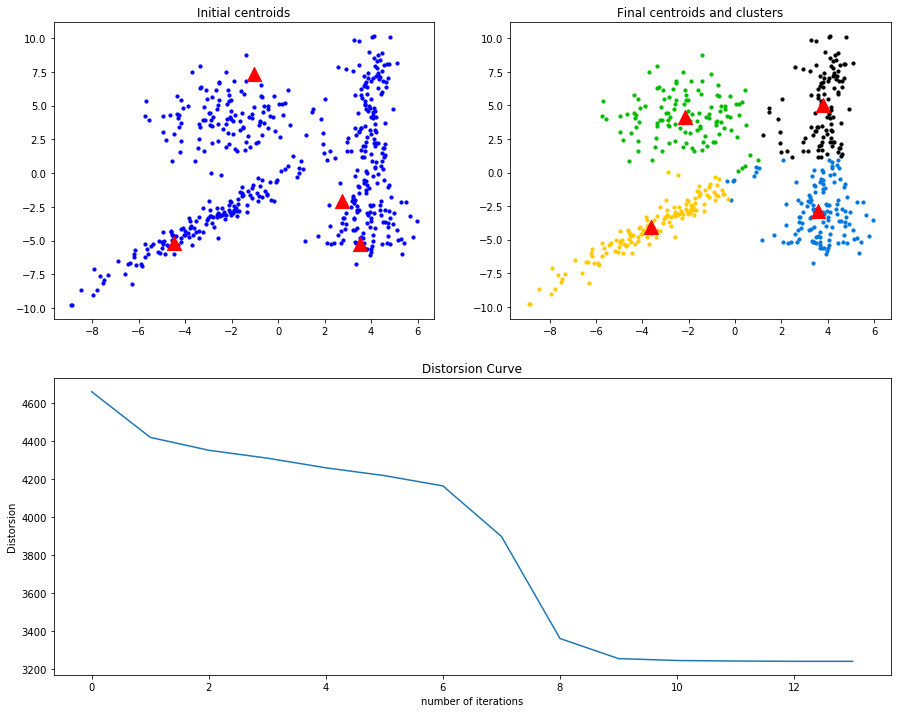

In [4]:
kmeans = Kmeans(data, 4)
clusters, centroids = kmeans.train()
kmeans.plot()

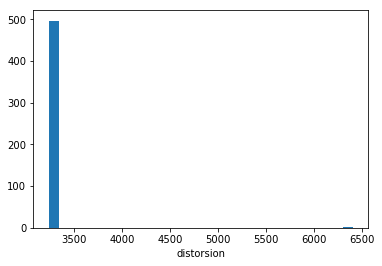

In [5]:
distorsions = []
for i in range(500):
    kmeans = Kmeans(data, 4)
    kmeans.train()
    distorsions.append(kmeans.getDistorsion())
plt.hist(distorsions, bins=30)
plt.xlabel('distorsion')

## 4. b) EM for isotropic model

In [5]:
from matplotlib.patches import Ellipse

# To plot the ellipse, I've found this stackoverflow subject:
# https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
# and I took this code from this github repository:
# https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [6]:
from scipy.stats import multivariate_normal

def predict(data, pi, means, cov):
    K = len(pi)
    n = len(data)
    p = np.zeros((K, n))
    for k in range(K):
        p[k] = pi[k] * (multivariate_normal.pdf(data, means[k], cov[k]))
    return np.argmax(p, axis= 0)

def isotropic_em(data, K, iter=100):
    # number of pts
    n, d = data.shape

    # initialize probability pi_{k} uniformly
    pi = [1/K] * K
    
    # initialize means with k-means
    kmeans = Kmeans(data, 4)
    cluster, means = kmeans.train()
    
    # isotropic covariance
    cov = [np.eye(2,2)]*4
    
    # tho[k][i] = p(z_i = k | x_i ; \theta)
    tho = np.zeros(shape=(K,n))
    
    for i in range(iter):
        # E step
        for k in range(K):
            tho[k, :] = pi[k]*multivariate_normal.pdf(data, mean=means[k], cov=cov[k])
        
        tho = tho/tho.sum(axis=0)
        # M step
        
        # update pi
        pi = tho.mean(axis=1)
        
        # update the means
        means = tho.dot(data)/(pi[:, np.newaxis]*n)
        
        # update the covariance
        for k in range(K):
            cov[k] = tho[k,:].dot(np.sum((data.values - means[k,:])**2, axis=1)) / (sum(tho[k]) * d) * np.eye(d)
    
    return (pi, means, cov, cluster)

In [7]:
pi, means, cov, cluster = isotropic_em(data, 4)
cluster = predict(data, pi, means, cov)

In [8]:
def gaussianPlot(data, means, cov, cluster):
    plt.figure(figsize=(10,10))
    K = means.shape[0]
    cm = plt.cm.get_cmap('nipy_spectral')
    colors = cm([k/K for k in range(K)])
    
    plt.xlim([-10, 10])
    plt.xlim([-10, 10])
    
    for k, c in zip(range(K), colors):
        plt.scatter(data[0][cluster == k], data[1][cluster == k], color=c, marker='o')
        plot_cov_ellipse(cov[k], means[k], color=c, nstd=2, fill=True, alpha=0.3)
    plt.scatter(means[:,0], means[:,1], color="red", marker="^", s=200)

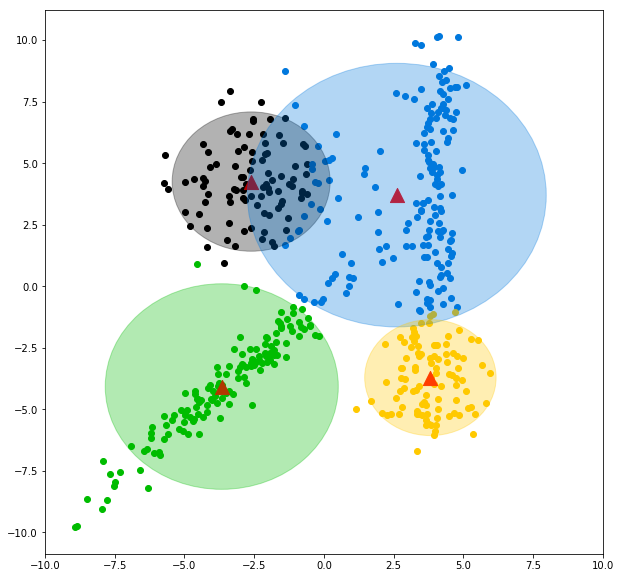

In [9]:
gaussianPlot(data, means, cov, cluster)

## 4. c) General Gaussian mixtures

In [10]:
from scipy.stats import multivariate_normal

def general_em(data, K, iter=100):
    # number of pts
    n = data.shape[0]

    # initialize probability pi_{k} uniformly
    pi = [1/K] * K
    
    # initialize means with k-means
    kmeans = Kmeans(data, 4)
    cluster, means = kmeans.train()
    
    # isotropic covariance
    cov = [np.eye(2,2)]*4
    
    # tho[k][i] = p(z_i = k | x_i ; \theta)
    tho = np.zeros(shape=(K,n))
    
    for i in range(iter):
        # E step
        for k in range(K):
            tho[k, :] = pi[k]*multivariate_normal.pdf(data, mean=means[k], cov=cov[k])
        
        tho = tho/tho.sum(axis=0)
        
        # M step
        
        # update pi
        pi = tho.mean(axis=1)
        
        # update the means
        means = tho.dot(data)/(pi[:, np.newaxis]*n)
        
        # update the covariance
        for k in range(K):
            cov[k] = np.array((tho[k, :, np.newaxis]*(data.values - means[k])).T.dot((data.values - means[k]))/tho[k, :].sum())
    
    return (pi, means, cov, cluster)

[[-3.06196072 -3.53454048]
 [ 3.80070949 -3.7972974 ]
 [ 3.97793026  3.77333066]
 [-2.03436695  4.17258596]]
[array([[ 6.24140911,  6.05017465],
       [ 6.05017465,  6.1824553 ]]), array([[ 0.92127926,  0.0573808 ],
       [ 0.0573808 ,  1.86586022]]), array([[  0.21035667,   0.29045083],
       [  0.29045083,  12.23996576]]), array([[ 2.90442381,  0.20655763],
       [ 0.20655763,  2.75617077]])]
[ 0.30555552  0.18290156  0.25998573  0.25155719]


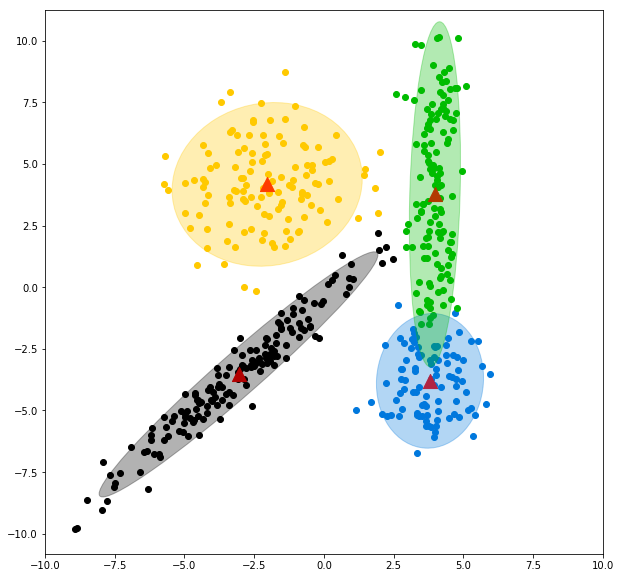

In [12]:
pi2, means2, cov2, cluster2 = general_em(data, 4)
cluster2 = predict(data, pi2, means2, cov2)
gaussianPlot(data, means2, cov2, cluster2)
print(means2)
print(cov2)
print(pi2)

In [13]:
# compute complete log likelihood
def complete_log_likelihood(data, pi, mu, cov, cluster):
    n = data.shape[0] # number of observations
    K = len(pi) # number of centroids
    res = 0
    for k in range(K):
        res += (cluster == k)*(np.log(pi[k]) + np.log(multivariate_normal.pdf(data, mean=mu[k,:], cov=cov[k])))
    return res.sum()

# compute log likelihood
def log_likelihood(data, pi, mu, cov):
    N = data.shape[0] # number of observations
    K = len(pi) # number of centroids
    res = 0
    for n in range(N):
        tmp = 0
        for k in range(K):
            tmp += pi[k] * (multivariate_normal.pdf(data.values[n], mean=mu[k,:], cov=cov[k]))
        res += np.log(tmp)
    return res.sum()

In [14]:
data_test = pd.read_csv('EMGaussian.test', sep=" ", header=None)

print("log-likelihood with isotropic model (Training set): ", log_likelihood(data, pi, means, cov))
print("log-likelihood with general model (Training set): ", log_likelihood(data, pi2, means2, cov2))
print("log-likelihood with isotropic model (Testing set): ", log_likelihood(data_test, pi, means, cov))
print("log-likelihood with general model (Training set): ", log_likelihood(data_test, pi2, means2, cov2))

log-likelihood with isotropic model (Training set):  -2639.56925683
log-likelihood with general model (Training set):  -2327.71567492
log-likelihood with isotropic model (Testing set):  -2614.60351039
log-likelihood with general model (Training set):  -2408.97815366
